<center> <img src="http://oci02.img.iteso.mx/identidad_de_instancia_2018/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" align="center" width="960" height="480"/> </center>

<center><font color=#555555><font size=6> MAF1731 - Microstructure and Trading Systems </font> <br> <br>
    
<center><font color=#555555><font size=5> B.Eng Financial Engineering </font> <br> <br> <br> <br>

<center><font color=#555555><font size=5> I.F. RENATTA GARCIA SANCHEZ</font> <br> <br>
    
<center><font color=#555555><font size=5>I. F. MARIO ABEL GARCIA VERDUZCO</font> <br> <br>
    
<center><font color=#555555><font size=5>I. F. ALEJANDRO MICHEL MARRON</font> <br> <br>
   
<center> <font color= #555555> <font size = 4> July 2021 </a> | <font color= #555555> <font size = 4> Repository: <a href='https://github.com/HKael/myst_proyecto_eq4'>Link</a></font>

<hr style="border:0.02in solid gray"> </hr>

<center> <font color= #555555> <font size = 6> Lab 5:  </font> <br> <br> <font color= #555555> <font size = 5> Currency Pair Fundamental Analysis  </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

<font color= #555555> <font size = 5> Abstract </font>

<font color= #6B6B6B> <font size = 4>  
This work aims to analyze how an economic indicator can generate temporal patterns in the time series of a financial asset; in this work we explore the asset USD/CHF with the Unemployment Rate indicator specifically. With these price reactions to the indicator, we hope to detect patterns and utilize them for constructing a trading system. </font>

<br>

# <font color= #6B6B6B> <font size = 6> 1. Introduction </font>

<hr style="border:0.02in solid gray"> </hr>

<p style='text-align: justify;'><font size = 3>  In this work for the  Microstructure and Trading Systems course, we searched for seasonal patterns in 30 minutes windows based on the Unemployment rate indicator and the impact on the USD/CHF currency pair time series. We divided this data into a training section and a test section. From the training data, we identified four scenarios and based on that. We designed a trading strategy for each of the four scenarios.

The following work is divided into four stages: 
<br>
    
    
    
- **Financial aspects**: We made an empirical validation with graphs and also a practical capital administration strategy.
- **Statistical aspects**: Autocorrelation and Partial Autocorrelation, Heteroscedasticity Test, etc...
- **Computational Aspects**: Escenarios structure and calculus per time window
- **Trading system definition**: we mentioned  four criteria for the system
- **Backtest and optimization**
- **Profitability**
- **MAD**
    </font></p> 

<br>

# <font color= #6B6B6B> 2. Install/Load Packages and Depedencies </font>

<hr style="border:0.02in solid gray"> </hr>

## <font color= #6B6B6B> 2.2 Python Packages </font> <font color= #555555>

In order to run this notebook, it is necessary to have installed and/or have the _requirements.txt_ file with the following: 

- pandas>=1.1.0
- numpy>=1.19.1
- jupyter>=1.0.0
- chart_studio>=1.1
- plotly>=4.14
- statsmodels
- MetaTrader5

## <font color= #6B6B6B> 2.3 Files Dependencies </font> <font color= #555555>

The following are the file dependencies that are needed to run this notebook:

- files\\Unemployment Rate - United States.csv : United States Unemployment Rate historical data

## <font color= #6B6B6B> 2.4 Install Packages </font> <font color= #555555>
Run the following cell to install the required packages for the project


In [37]:
%%capture

# Install all the pip packages in the requirements.txt

import sys
!{sys.executable} -m pip install -r requirements.txt

## <font color= #6B6B6B> 2.5 Run Packages </font> <font color= #555555>

In [2]:
import pandas as pd 
import functions as fn
import data as dt
import visualizations as vs
import main as mn
import functions_PyMetatrader5 as fnmt5
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import stats
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
import pyswarms as ps

import warnings
warnings.filterwarnings('ignore')
pd.DataFrame.less = lambda df, n=10: df.head(n//2).append(df.tail(n//2))

# <font color= #6B6B6B> 3. Data Description </font>

<hr style="border:0.02in solid gray"> </hr>

### <font color= #6B6B6B> Unemployment Rate data </font>

<p style='text-align: justify;'>The first file that we're going to consider is the <strong>Unemployment Rate</strong> historic data released by the US Bureau of Labor Statistics is a percentage that surges from dividing the number of unemployed workers by the total civilian labor force. It represents the percentage of people actively seeking employment and willing to work. Usually, as a higher rate is seen in recessionary economies, while on the ​contrary, a growing economy sees its unemployment rate decreasing. Therefore, a decrease of the figure is seen as positive (or bullish) for the USD, while an increase is seen as negative (or bearish), although by itself, the number can't determinate the markets move as it depends on the headline reading, the Nonfarm Payroll. 
    
Ex:</p> 

In [3]:
# Archivo con el índice a usar
indice = pd.read_csv('files\\Unemployment Rate - United States.csv', index_col='DateTime')
# Eliminar columan de revised
indice.drop('Revised', axis=1, inplace=True)
# Convertir a datetime la columna de fechas
indice.index = pd.to_datetime(indice.index)

# Faltante en previous
indice.iloc[-1]['Previous'] = indice.iloc[-2]['Actual']
indice.less(5)

,Actual,Consensus,Previous
DateTime,,,
2020-02-07 13:30:00,3.6,3.5,3.5
2020-01-10 13:30:00,3.5,3.5,3.5
2007-04-06 12:30:00,4.4,4.6,4.5
2007-03-09 13:30:00,4.5,4.6,4.4


### <font color= #6B6B6B> USD/CHF pair price per minute</font>

Also, we used prices per minute of the USD/CHF downloaded from MetaTrader5

In [4]:
# Datos mt5
local_exe = 'C:\\Program Files\\MetaTrader 5\\terminal64.exe'
# local_exe = 'C:\\Program Files\\MetaTrader 5 Terminal\\terminal64.exe'
#local_exe = 'C:\\Archivos de programa\\MetaTrader 5 Terminal\\terminal64.exe'

# Número de cuenta
mt5_acc = 5383442
# Contraseña
mt5_pass = "44GxKTtf"
# Inicialización de mt5
mt5_client = fnmt5.f_init_login(mt5_acc, mt5_pass, local_exe)

# Escenarios para validaciones visuales
symbol = 'USDCHF'
escenario1, escenario2, escenario3, escenario4, escenario5 = fn.validadiciones(indice, mt5_client, symbol)

 ++++ init_login succeded, message =  True


In [5]:
escenario1.less(5)

,time,open,high,low,close,tick_volume,spread,real_volume
0,2016-06-03 12:30:00,0.99184,0.99187,0.99174,0.99183,58,20,891500000
1,2016-06-03 12:31:00,0.99184,0.99186,0.99179,0.99185,39,20,562000000
29,2016-06-03 12:59:00,0.99160,0.99161,0.99116,0.99122,67,21,65230000
30,2016-06-03 13:00:00,0.99123,0.99128,0.99112,0.99114,72,21,95850000


# <font color= #6B6B6B> 4. Financial Aspects
</font>

<hr style="border:0.02in solid gray"> </hr>

### <font color= #6B6B6B>Visual Validation #1 </font>

In [6]:
vs.candle_stick_plot(escenario1)

In [7]:
indice[escenario1.iloc[0]['time'].strftime('%Y-%m-%d')]

,Actual,Consensus,Previous
DateTime,,,
2016-06-03 12:30:00,4.7,4.9,5.0


**Price Reaction:** We see that the actual value was less than consensus and previous, so we ended with a lower price for each USD in our 30 minutes window.

In [8]:
fn.op(escenario1, "Sell")

,Operation Parameter,Operation Value
0,TimeStamp,2016-06-03 12:30:00
1,Window,00:30:00
2,Initial Price,$ 0.99184
3,Final Price,$ 0.99123
4,Maximum Price,$ 0.99193
5,Minimum Price,$ 0.99112
6,Stop Loss,$ 0.9919192912000001
7,Take Profit,$ 0.9917210632000001
8,Volume,1008
9,Capital,1000 USD


### <font color= #6B6B6B>Visual Validation #2 </font>

In [9]:
vs.candle_stick_plot(escenario2)

In [10]:
indice[escenario2.iloc[0]['time'].strftime('%Y-%m-%d')]

,Actual,Consensus,Previous
DateTime,,,
2019-09-06 12:30:00,3.7,3.7,3.7


**Price Reaction:**
The actual value was the same as consensus and previous, and we ended with a slightly upper price for each USD in our 30 minutes window.

In [11]:
fn.op(escenario2, "Buy")

,Operation Parameter,Operation Value
0,TimeStamp,2019-09-06 12:30:00
1,Window,00:30:00
2,Initial Price,$ 0.98965
3,Final Price,$ 0.98982
4,Maximum Price,$ 0.99011
5,Minimum Price,$ 0.98925
6,Stop Loss,$ 0.9895708176
7,Take Profit,$ 0.9897687736
8,Volume,1010
9,Capital,1000 USD


### <font color= #6B6B6B>Visual Validation #3 </font>

In [12]:
vs.candle_stick_plot(escenario3)

In [13]:
indice[escenario3.iloc[0]['time'].strftime('%Y-%m-%d')]

,Actual,Consensus,Previous
DateTime,,,
2016-11-04 12:30:00,4.9,4.9,5.0


**Price Reaction:**
The actual value was the same as the consensus but lower than the previous, so we ended with a slightly lower price for each USD in our 30 minutes window.

In [14]:
fn.op(escenario3, "Sell")

,Operation Parameter,Operation Value
0,TimeStamp,2016-11-04 12:30:00
1,Window,00:30:00
2,Initial Price,$ 0.97364
3,Final Price,$ 0.9733
4,Maximum Price,$ 0.97385
5,Minimum Price,$ 0.97319
6,Stop Loss,$ 0.9737178679999999
7,Take Profit,$ 0.973523198
8,Volume,1027
9,Capital,1000 USD


### <font color= #6B6B6B>Visual Validation #4 </font>

In [15]:
vs.candle_stick_plot(escenario4)

In [16]:
indice[escenario4.iloc[0]['time'].strftime('%Y-%m-%d')]

,Actual,Consensus,Previous
DateTime,,,
2009-05-08 12:30:00,8.9,8.9,8.5


**Price Reaction:**
The actual value was the same as the consensus but higher than the previous. Also, we ended with a slightly lower price for each USD in our 30 minutes window.

In [17]:
fn.op(escenario4, "Sell")

,Operation Parameter,Operation Value
0,TimeStamp,2009-05-08 12:30:00
1,Window,00:30:00
2,Initial Price,$ 1.1299
3,Final Price,$ 1.1289500000000001
4,Maximum Price,$ 1.13076
5,Minimum Price,$ 1.12847
6,Stop Loss,$ 1.1299903111999998
7,Take Profit,$ 1.1297645332
8,Volume,885
9,Capital,1000 USD


### <font color= #6B6B6B>Visual Validation #5 </font>

In [18]:
vs.candle_stick_plot(escenario5)

In [19]:
indice[escenario5.iloc[0]['time'].strftime('%Y-%m-%d')]

,Actual,Consensus,Previous
DateTime,,,
2016-12-02 13:30:00,4.6,4.9,4.9


**Price Reaction:**
The actual value was lower than consensus and previous. We ended with a slightly higher price for each USD in our 30 minutes window.

In [20]:
fn.op(escenario5, "Buy")

,Operation Parameter,Operation Value
0,TimeStamp,2016-12-02 13:30:00
1,Window,00:30:00
2,Initial Price,$ 1.01144
3,Final Price,$ 1.01151
4,Maximum Price,$ 1.01187
5,Minimum Price,$ 1.01104
6,Stop Loss,$ 1.0113590711999998
7,Take Profit,$ 1.0115613931999998
8,Volume,988
9,Capital,1000 USD


# <font color= #6B6B6B> 5. Statistical Aspects
</font>

<hr style="border:0.02in solid gray"> </hr>

### <font color= #6B6B6B> Autocorrelation and Partial Autocorrelation Functions
</font>

Just as correlation measures the extent of a linear relationship between two variables, autocorrelation (ACF) measures the linear relationship between lagged values of a time series. In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

This function plays an important role in data analysis aimed at identifying the extent of the lag in an autoregressive model. 


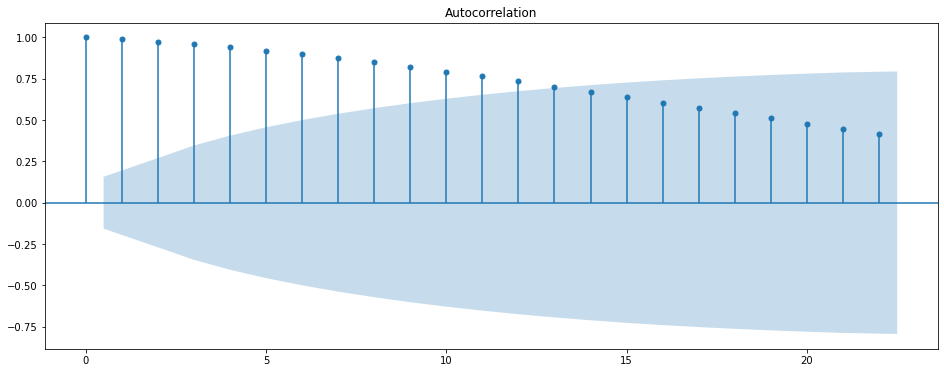

In [21]:
indice_stats = indice
indice_stats = indice_stats.reset_index()
fn.acf(indice_stats["Actual"])

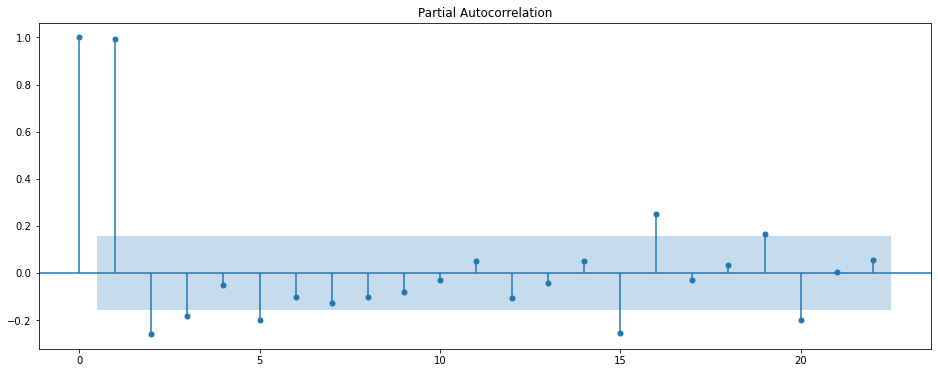

In [22]:
fn.pacf(indice_stats["Actual"])

### <font color= #6B6B6B> Heteroscedasticity Test
</font>

Heteroscedasticity means unequal scatter. The concept of heteroscedasticity - the opposite being homoscedasticity - is used in statistics, especially in the context of linear regression or for time series analysis, to describe the case where the variance of errors or the model is not the same for all observations, while often one of the basic assumption in modeling is that the variances are homogeneous and that the errors of the model are identically distributed.

In linear regression analysis, the fact that the errors of the model (also named residuals) are not homoskedastic has the consequence that the model coefficients estimated using ordinary least squares (OLS) are neither unbiased nor those with minimum variance. The estimation of their variance is not reliable.

<font color= #6B6B6B> <font size = 4> Regression
</font>

In [23]:
fn.regression(indice_stats.index, indice_stats["Actual"])

                            OLS Regression Results                            
Dep. Variable:                 Actual   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     85.35
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           1.90e-16
Time:                        03:52:51   Log-Likelihood:                -301.03
No. Observations:                 156   AIC:                             606.1
Df Residuals:                     154   BIC:                             612.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1628      0.267     15.573      0.0

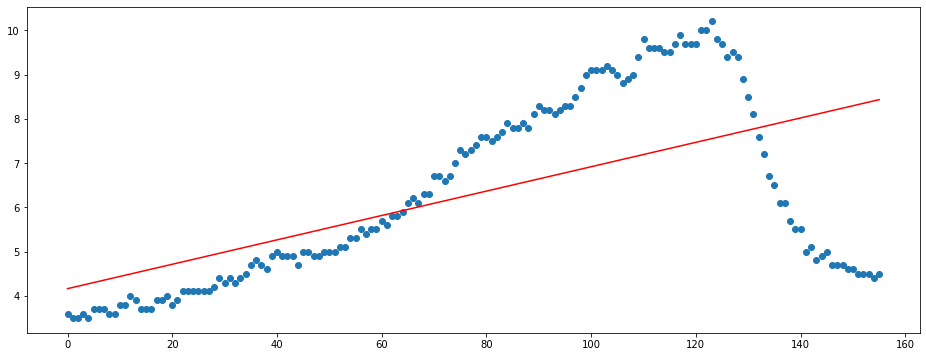

In [24]:
fn.regression_v(indice_stats.index, indice_stats["Actual"])

In statistics, the Breusch–Pagan test, developed in 1979 by Trevor Breusch and Adrian Pagan, is used to test for heteroskedasticity in a linear regression model. It was independently suggested with some extension by R. Dennis Cook and Sanford Weisberg in 1983 (Cook–Weisberg test). Derived from the Lagrange multiplier test principle, it tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroskedasticity is present.

In [25]:
fn.heteroskedasticity(indice_stats)

LM Statistic: 19.950616
LM Statistic p-value: 0.000008
F-Statistic: 11.291469
F-Statistic p-value: 0.000027
Heteroskedasticity is indicated if p <0.05, so according to these tests, this model is heteroskedastic.


### <font color= #6B6B6B> Normality Test
</font>

Normality tests are used to determine if a data set is well-modeled by a normal distribution and to compute how likely it is for a random variable underlying the data set to be normally distributed. The normal distribution is a theoretical distribution. What you are really testing with the normality test is not whether your data is exactly consistent with a normal distribution, but whether your data is close enough to normal that you can use your statistical tool without concern.

The Shapiro-Wilk test, published in 1965 by Samuel Sanford Shapiro and Martin Wilk, was used.

In [26]:
fn.norm_test(indice_stats["Actual"])

Statistics=0.906, p=0.000
Sample does not look Gaussian (reject H0)
Sample does not have normal distribution


### <font color= #6B6B6B> Stationarity
</font>

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


In [27]:
fn.stationarity(indice_stats["Actual"])

ADF Statistic: -1.672648
p-value: 0.445257
Critical Values:
No stationarity detected


### <font color= #6B6B6B> Seasonality
</font>

Time series data may contain seasonal variation. Seasonal variation, or seasonality, are cycles that repeat regularly over time. A repeating pattern within each year is known as seasonal variation, although the term is applied more generally to repeating patterns within any fixed period.

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
Non-Systematic: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

-Level: The average value in the series.

-Trend: The increasing or decreasing value in the series.

-<font color= green> Seasonality: The repeating short-term cycle in the series. </font>

-Noise: The random variation in the series.

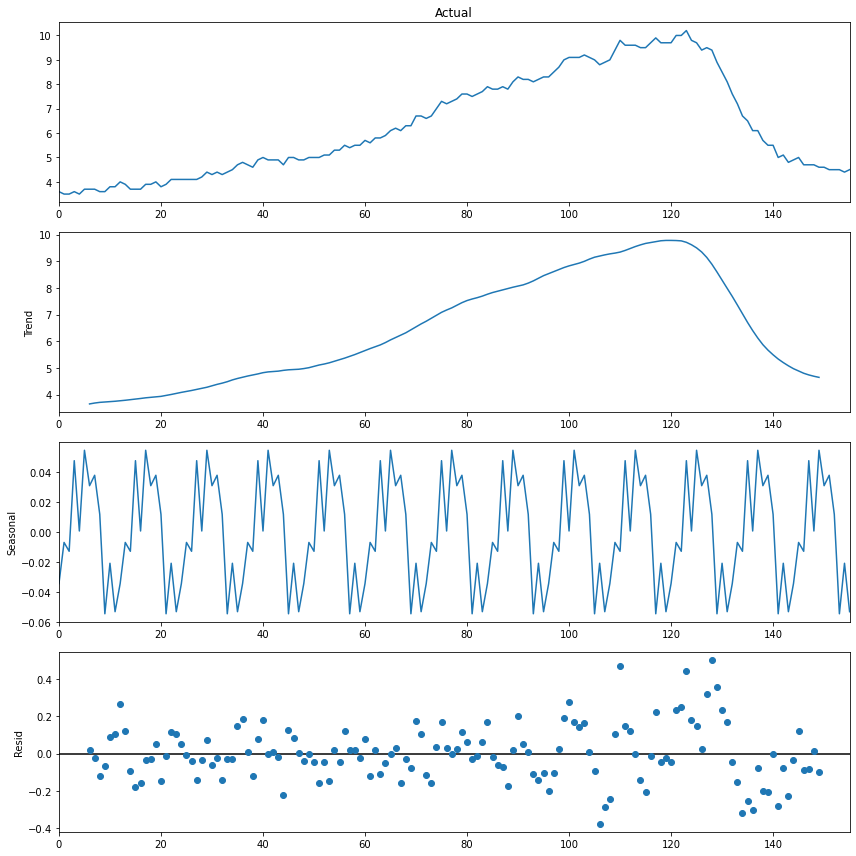

In [28]:
fn.seasonality(indice_stats["Actual"])

### <font color= #6B6B6B> Outlier detection
</font>

An outlier is an observation that appears to deviate markedly from other observations in the sample.
Identification of potential outliers is important for the following reasons.

An outlier may indicate bad data. For example, the data may have been coded incorrectly or an experiment may not have been run correctly. If it can be determined that an outlying point is in fact erroneous, then the outlying value should be deleted from the analysis (or corrected if possible).
In some cases, it may not be possible to determine if an outlying point is bad data. Outliers may be due to random variation or may indicate something scientifically interesting. In any event, we typically do not want to simply delete the outlying observation. However, if the data contains significant outliers, we may need to consider the use of robust statistical techniques.

In statistics, Grubbs's test or the Grubbs test, also known as the maximum normalized residual test or extreme studentized deviate test, is a test used to detect outliers in a univariate data set assumed to come from a normally distributed population.

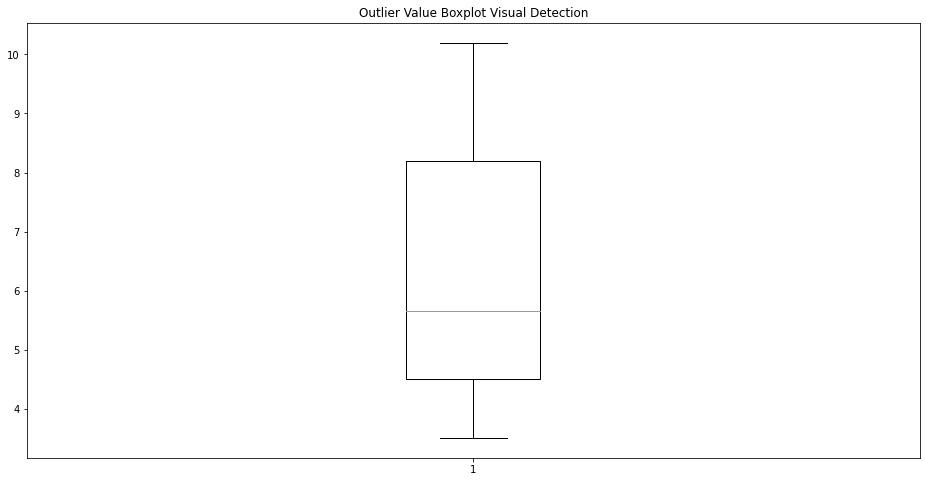

No outliers detected


In [29]:
fn.outlier_v(indice_stats["Actual"])

# <font color= #6B6B6B> 6. Computational Aspects
</font>

<hr style="border:0.02in solid gray"> </hr>

### <font color= #6B6B6B> Scenarios and Rules
</font>

We categorize the occurrences this way:

| Scenario |       Rule |
|:-------------|:-----------|
|A | Actual >= Consensus >= Previous |
|B | Actual >= Consensus <  Previous |
|C | Actual <  Consensus >= Previous |
|D | Actual <  Consensus <  Previous |



And for each identified scenario, we calculated his trend, downward & upward pips, and volatility:

In [30]:
df_escenarios = fn.func_df_escenarios(indice, symbol, mt5_client)
df_escenarios, i = fn.func_df_escenarios(indice, symbol, mt5_client)
df_escenarios.less(5)

,Escenario,Direccion,pip_alcistas,pips_bajistas,volatilidad
DateTime,,,,,
2020-02-07 13:30:00,A,-1,5.6,1.0,12.7
2020-01-10 13:30:00,A,1,0.7,5.0,11.3
2007-04-06 12:30:00,C,-1,6.0,0.0,8.0
2007-03-09 13:30:00,C,1,5.0,4.0,15.0


### <font color= #6B6B6B> Trading Strategy
</font>

With the test values, we designed the following **trading strategy**:

- For **scenario "A"**, we decided to buy. Because all test values were on an upward trend. 14 pips on take profit, since the maximum pips on an upward trend were 1 but with a volatility of 14 pips. Stop loss on 12, seeing that it was the minimum of the downward pips. With 80 lots of volume to limit max. loss to $960.

- We decided to sell on **scenario "B"** because the downward trend scenarios' volatility was less. A take profit of 8 pips because the max of the downward pips was 5, but with a volatility of 8. Stop loss on 5 pips since this was the max on upward pips. Finally, a volume of 200 to limit max losses exactly on $1,000

- We buy on **scenario "C"**. Because all test values were on an upward trend. 15 pips on take profit. Stop loss on 9, seeing that it was the minimum of the downward pips. With 110 lots of volume to limit max. loss.

- **Scenario "D"** also was a buy. Since all test values were on an upward trend. 7 pips on take profit. Stop loss on 4 because it was the minimum of the downward pips. With 250 lots of volume to limit max. loss.


<br>

# <font color= #6B6B6B> <font size = 6> 7. Backtesting and optimization </font>

<hr style="border:0.02in solid gray"> </hr>

### <font color= #6B6B6B> Parameters:
</font>

1. Inicial capital: $100,000 usd

2. Maximum risk per operation (max loss): $1,000 usd

3. We divided our data this way:
    - training period: 01/Jan/2018 - 01/Jan/2019 
    - test period 01/Feb/2019 - 01/Feb/2020

### <font color= #6B6B6B> Backtesting</font>

In [34]:
mn.df_decisiones

,escenario,operacion,sl,tp,volumen
0,A,compra,14,12,80
1,B,venta,8,5,200
2,C,compra,15,9,110
3,D,compra,7,4,250


In [50]:
mn.df_backtest.tail(5)

,escenario,operacion,volumen,resultado,pips,capital,capital_acm
DateTime,,,,,,,
2018-05-04 12:30:00,D,compra,250,perdida,7.0,-1750.0,94530.0
2018-04-06 12:30:00,B,venta,200,ganada,5.7,1140.0,95670.0
2018-03-09 13:30:00,B,venta,200,perdida,2.7,-540.0,95130.0
2018-02-02 13:30:00,A,compra,80,perdida,4.2,-336.0,94794.0
2018-01-05 13:30:00,A,compra,80,ganada,0.2,16.0,94810.0


En esta estrategia vampos perdiendo dinero

In [46]:
mn.df_prueba_no

AttributeError: module 'main' has no attribute 'df_prueba_no'

### <font color= #6B6B6B> Optimization
</font>

Hacemos proceso de opt con PSO con parametros de busqueda

In [37]:
mn.df_desopt

,escenario,operacion,sl,tp,volumen
0,A,compra,5.098410,12.761698,361525.886535
1,B,venta,4.684464,17.897255,286549.850635
2,C,compra,1.712228,3.586744,52445.715194
3,D,compra,1.986556,5.178909,107608.267229


In [ ]:
estos son los resultados de la opt

In [49]:
mn.df_backtest_opt.tail(5)

,escenario,operacion,volumen,resultado,pips,capital,capital_acm
DateTime,,,,,,,
2018-05-04 12:30:00,D,compra,107608.267229,perdida,9.3,-1.000757e+06,-9.787807e+06
2018-04-06 12:30:00,B,venta,286549.850635,ganada,5.7,1.633334e+06,-8.154473e+06
2018-03-09 13:30:00,B,venta,286549.850635,perdida,2.7,-7.736846e+05,-8.928157e+06
2018-02-02 13:30:00,A,compra,361525.886535,perdida,4.2,-1.518409e+06,-1.044657e+07
2018-01-05 13:30:00,A,compra,361525.886535,ganada,0.2,7.230518e+04,-1.037426e+07


In [ ]:
evoluvión del capital con la optimización

In [47]:
mn.df_prueba_opt 

AttributeError: module 'main' has no attribute 'df_prueba_opt'

### <font color= #6B6B6B> Comparations:
</font>

In [48]:
vs.opt_no_opt(mn.df_backtest_opt, mn.df_backtest) 

AttributeError: module 'visualizations' has no attribute 'opt_no_opt'

# <font color= #6B6B6B> <font size = 6> 8. MAD </font>

<hr style="border:0.02in solid gray"> </hr>

<br>

# <font color= #6B6B6B> <font size = 6> 9. References </font>

<hr style="border:0.02in solid gray"> </hr>

[1] Munnoz, 2020. Python project template. https://github.com/iffranciscome/python-project. (2021).

[2] Box, G. E. P., and Jenkins, G. (1976), Time Series Analysis: Forecasting and Control, Holden-Day.

[3] Jason Brownlee. (2016). How to Identify and Remove Seasonality from Time Series Data with Python. 07/013/2021, de Machine Learning Mastery Sitio web: https://machinelearningmastery.com/time-series-seasonality-with-python/#:~:text=Time%20series%20data%20may%20contain,patterns%20within%20any%20fixed%20period.

[4] Grubbs, Frank (February 1969), Procedures for Detecting Outlying Observations in Samples, Technometrics, 11(1), pp. 1-21.


[5] Remy Canario. (2019). Beyond QQ Plots: Tests for Heteroskedasticity in Python. 07/14/2021, de Medium Sitio web: https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab

<br>